# Import libraries

In [397]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

# Explore data

First, we are not working with tabular data but with unstructured data because the data is images.
Therefore, there is not much of a need to use df.describe for the descriptive statistics.
Also no need for df.info as the dataframe is self-explanatory. There is no null values.

1. `Origin`: where the data is from, either Chars74K or MNIST datasets.
2. `Group`: the segment of the image's quality. It holds values of Hnd (hand written), Fnt (computer font), GoodImg (natural scenes with good quality) and BadImg (natural scenes with bad quality).
3. `File`: file path of the images' location.
4. `Label`: the images' digit/number.

We will make a copy of the original data before continuing.

In [398]:
original_df = pd.read_csv('./data/numbers.csv')
df = original_df.copy()
df.sort_values('label')

,origin,group,label,file
71589,mnist,Hnd,0,mnist_png/Hnd/Sample0/49278.png
66923,mnist,Hnd,0,mnist_png/Hnd/Sample0/7985.png
66924,mnist,Hnd,0,mnist_png/Hnd/Sample0/33087.png
66925,mnist,Hnd,0,mnist_png/Hnd/Sample0/2996.png
66926,mnist,Hnd,0,mnist_png/Hnd/Sample0/19845.png
...,...,...,...,...
55408,mnist,Hnd,9,mnist_png/Hnd/Sample9/5817.png
55407,mnist,Hnd,9,mnist_png/Hnd/Sample9/29536.png
55406,mnist,Hnd,9,mnist_png/Hnd/Sample9/37062.png
55416,mnist,Hnd,9,mnist_png/Hnd/Sample9/44592.png


In [399]:
df.isna().sum()

origin    0
group     0
label     0
file      0
dtype: int64

We have to take into account that there is no need for our digit recognition model to recognize the digit '0' because we are creating a model specialized for Sudoku. As a reminder, Sudoku is a puzzle that involves only the digits from 1-9. That is why we will be removing the 0.

Some advantages of doing so:
1. by focusing on the digits that are relevant to the task, the model will be more specialized and better suited for the intended application.
2. it simplifies the training process and reduces the complexity of the model, leading to a faster training time and potentially better performance on the digits relevant to the task.
3. it helps balance the distribution of digits in the dataset preventing the model from being biased towards the majority class (1-9) and improve its ability to generalize.

And we can see that the data for the 0 were 7147 and we will be dropping these values from the dataframe.


In [400]:
freq_0 = df['origin'].loc[df['label'] == 0].count()
print(f'Count of the digit 0 in the dataset: {freq_0}')

df = df.loc[df['label'] != 0]
df['label'].value_counts().sort_index()


Count of the digit 0 in the dataset: 7147


label
1    7938
2    7147
3    7274
4    6986
5    6573
6    7073
7    7397
8    6964
9    7091
Name: count, dtype: int64

We can see that after removing 0's in our dataset we have 54,077 images from the MNIST and 10,366 images from Chars74K.
So approximately 84% belongs to MNIST and 16% to Chars74k.
This ratio will be used for stratified sampling of train and test sets along with the proportion of the 'group' and 'label' features.

In [401]:
df_datasets = df['origin'].value_counts().reset_index()
df_datasets['ratio'] = df_datasets['count'] / df_datasets['count'].sum()
df_datasets

,origin,count,ratio
0,mnist,54077,0.839145
1,chars74k,10366,0.160855


We will further see the count of each label within it's group.
The MNIST dataset only contains handwritten digits while the Chars74k contains bad images, good images, and computer fonts as well.
Now we are ready to separate the origin of the datasets.

In [402]:
df_labels = df.groupby(['origin','group','label'])['file'].count().reset_index()
df_labels['ratio'] = df_labels['file'] / df_labels['file'].sum()
df_labels

,origin,group,label,file,ratio
0,chars74k,BadImag,1,48,0.000745
1,chars74k,BadImag,2,48,0.000745
2,chars74k,BadImag,3,22,0.000341
3,chars74k,BadImag,4,26,0.000403
4,chars74k,BadImag,5,17,0.000264
5,chars74k,BadImag,6,20,0.000310
6,chars74k,BadImag,7,13,0.000202
7,chars74k,BadImag,8,10,0.000155
8,chars74k,BadImag,9,37,0.000574
9,chars74k,Fnt,1,1016,0.015766


We will decide to remove the bad quality images (BadImag) because we are not going to deploy the model to recognize bad quality digits and also the amount of pictures are way too few to have a positive effect on the model.

In [403]:
df_mnist = df.loc[df['origin']=='mnist']
df_chars74k = df.loc[(df['origin']=='chars74k') & (df['group']!='BadImag')]

Notice that for the MNIST dataset, the group feature's information is quite insignificant to keep because it has only one category, which is handwritten digits so it is okay to drop the whole column.  

The group for the Chars74k set will be kept to use for the parameter 'stratify' later when we split the train and test sets.  

Finally, the 'origin' column for both datasets will be dropped afterwards because we only need the location of the files (which will be read and the images be converted into an array of pixels for 'X') and the label (which will be the 'y').  

`explanatory variables`: X (array of dimensions: m,n where m is individual data and n is amount of pixels)  
`target variable`: y (array of single dimension (m,) where m is label for each individual data)

In [404]:
try:
    df_mnist.drop(columns='group', inplace=True)
except KeyError:
    print('The column "group" has already been dropped.')
df_mnist.sort_values('label').head()

/var/folders/qz/5wqlq53516nf38l3j5wtkvmh0000gn/T/ipykernel_53728/2903635121.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mnist.drop(columns='group', inplace=True)


,origin,label,file
38628,mnist,1,mnist_png/Hnd/Sample1/3963.png
37325,mnist,1,mnist_png/Hnd/Sample1/18266.png
37326,mnist,1,mnist_png/Hnd/Sample1/19346.png
37327,mnist,1,mnist_png/Hnd/Sample1/21972.png
37328,mnist,1,mnist_png/Hnd/Sample1/53823.png


In [405]:
df_chars74k.sort_values('label').head()

,origin,group,label,file
5167,chars74k,Fnt,1,chars74k_png/Fnt/Sample1/img002-00203.png
5046,chars74k,Fnt,1,chars74k_png/Fnt/Sample1/img002-00186.png
5045,chars74k,Fnt,1,chars74k_png/Fnt/Sample1/img002-00564.png
5044,chars74k,Fnt,1,chars74k_png/Fnt/Sample1/img002-00153.png
5043,chars74k,Fnt,1,chars74k_png/Fnt/Sample1/img002-00036.png


Now the data will be separated into X and y then we split the train and test sets with stratified sampling on the labels.

Let's start with the MNIST dataset because it is easier to do without the groups.

The steps will be:
1. work without the origin column as the variable name will hold the dataset's name.
2. separate the X and y.
3. check the shape to make sure the dimensions are right.
4. separate into train and test sets with the stratify parameter being the label feature.
5. then drop the label column from X because it was only used for stratification.
6. check the shape to make sure the dimensions are right again.

In [406]:
X_mnist = df_mnist[['file','label']]
y_mnist = df_mnist['label']

In [407]:
print(f'{X_mnist.shape = }')
print(f'{y_mnist.shape = }')

X_mnist.shape = (54077, 2)
y_mnist.shape = (54077,)


In [408]:
X_train_mnist, X_test_mnist, y_train_mnist, y_test_mnist = train_test_split(X_mnist, y_mnist, test_size=0.05, stratify=X_mnist['label'])
X_train_mnist, X_val_mnist, y_train_mnist, y_val_mnist = train_test_split(X_train_mnist, y_train_mnist, test_size=0.1, stratify=X_train_mnist['label'])

print(f'{X_train_mnist.shape = }')
print(f'{y_train_mnist.shape = }')
print(f'{X_val_mnist.shape = }')
print(f'{y_val_mnist.shape = }')
print(f'{X_test_mnist.shape = }')
print(f'{y_test_mnist.shape = }')

X_train_mnist.shape = (46235, 2)
y_train_mnist.shape = (46235,)
X_val_mnist.shape = (5138, 2)
y_val_mnist.shape = (5138,)
X_test_mnist.shape = (2704, 2)
y_test_mnist.shape = (2704,)


Now lets do the same procedure for the Chars74k dataset.

For this dataset first we have to loop into every group and then perform the train test split.

The steps will be:
1. get hold of the unique group feature values.
2. initialize an empty list to get hold of the X_train, X_test, y_train, y_test of each group.
3. perform the train test split with the stratify parameter being the label.
4. append each of the values to the empty list.
5. concatenate all the train test splits of every group.
6. check for the shapes to make sure the dimensions are right.

In [409]:
df_chars74k_groups = df_chars74k['group'].unique().tolist()
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []
for group in df_chars74k_groups:
    df_group = df_chars74k.loc[df['group'] == group]
    
    X_train_chars74k, X_test_chars74k, y_train_chars74k, y_test_chars74k = train_test_split(
        df_group[['file','label']], df_group['label'], test_size=0.05, stratify=df_group['label']
    )
    X_train_list.append(X_train_chars74k)
    X_test_list.append(X_test_chars74k)
    y_train_list.append(y_train_chars74k)
    y_test_list.append(y_test_chars74k)

X_train_chars74k = pd.concat(X_train_list)
X_test_chars74k = pd.concat(X_test_list)
y_train_chars74k = pd.concat(y_train_list)
y_test_chars74k = pd.concat(y_test_list)

X_train_chars74k, X_val_chars74k, y_train_chars74k, y_val_chars74k = train_test_split(
    X_train_chars74k, y_train_chars74k, test_size=0.1, stratify=X_train_chars74k['label']
)


print(f'{X_train_chars74k.shape = }')
print(f'{y_train_chars74k.shape = }')
print(f'{X_val_chars74k.shape = }')
print(f'{y_val_chars74k.shape = }')
print(f'{X_test_chars74k.shape = }')
print(f'{y_test_chars74k.shape = }')

X_train_chars74k.shape = (8655, 2)
y_train_chars74k.shape = (8655,)
X_val_chars74k.shape = (962, 2)
y_val_chars74k.shape = (962,)
X_test_chars74k.shape = (508, 2)
y_test_chars74k.shape = (508,)


Now lets check that the proportion of the groups were done correctly.  

Let's see the proportion of groups before and after the train test split. We will do so with only the X train just to save time.

In [410]:
df_mnist_labels = df_mnist.groupby('label')['file'].count().reset_index()
df_mnist_labels['ratio'] = df_mnist_labels['file'] / df_mnist_labels['file'].sum()
df_mnist_labels

X_test_mnist_labels = X_test_mnist.groupby('label')['file'].count().reset_index()
X_test_mnist_labels['ratio'] = X_test_mnist_labels['file'] / X_test_mnist_labels['file'].sum()
X_test_mnist_labels

df_mnist_labels, X_test_mnist_labels

(   label  file     ratio
 0      1  6742  0.124674
 1      2  5958  0.110176
 2      3  6131  0.113375
 3      4  5842  0.108031
 4      5  5421  0.100246
 5      6  5918  0.109437
 6      7  6265  0.115853
 7      8  5851  0.108198
 8      9  5949  0.110010,
    label  file     ratio
 0      1   337  0.124630
 1      2   298  0.110207
 2      3   307  0.113536
 3      4   292  0.107988
 4      5   271  0.100222
 5      6   296  0.109467
 6      7   313  0.115754
 7      8   293  0.108358
 8      9   297  0.109837)

In [411]:
df_chars74k_labels = df_chars74k.groupby('label')['file'].count().reset_index()
df_chars74k_labels['ratio'] = df_chars74k_labels['file'] / df_chars74k_labels['file'].sum()
df_chars74k_labels

X_test_chars74k_labels = X_test_chars74k.groupby('label')['file'].count().reset_index()
X_test_chars74k_labels['ratio'] = X_test_chars74k_labels['file'] / X_test_chars74k_labels['file'].sum()
X_test_chars74k_labels

df_chars74k_labels, X_test_chars74k_labels

(   label  file     ratio
 0      1  1148  0.113383
 1      2  1141  0.112691
 2      3  1121  0.110716
 3      4  1118  0.110420
 4      5  1135  0.112099
 5      6  1135  0.112099
 6      7  1119  0.110519
 7      8  1103  0.108938
 8      9  1105  0.109136,
    label  file     ratio
 0      1    58  0.114173
 1      2    58  0.114173
 2      3    57  0.112205
 3      4    55  0.108268
 4      5    57  0.112205
 5      6    57  0.112205
 6      7    55  0.108268
 7      8    55  0.108268
 8      9    56  0.110236)

Now we can drop the label columns for the X in both datasets

In [412]:
X_train_mnist.drop(columns='label', inplace=True)
X_test_mnist.drop(columns='label', inplace=True)
X_train_chars74k.drop(columns='label', inplace=True)
X_test_chars74k.drop(columns='label', inplace=True)

In [413]:
print(f'{X_train_chars74k.shape = }')
print(f'{y_train_chars74k.shape = }')
print(f'{X_test_chars74k.shape = }')
print(f'{y_test_chars74k.shape = }')
print(f'{X_train_mnist.shape = }')
print(f'{y_train_mnist.shape = }')
print(f'{X_test_mnist.shape = }')
print(f'{y_test_mnist.shape = }')

X_train_chars74k.shape = (8655, 1)
y_train_chars74k.shape = (8655,)
X_test_chars74k.shape = (508, 1)
y_test_chars74k.shape = (508,)
X_train_mnist.shape = (46235, 1)
y_train_mnist.shape = (46235,)
X_test_mnist.shape = (2704, 1)
y_test_mnist.shape = (2704,)


Now we are ready to concatenate both datasets into one X_train, X_test, y_train, y_test

In [414]:
X_train = pd.concat([X_train_chars74k, X_train_mnist])
y_train = pd.concat([y_train_chars74k, y_train_mnist]) - 1
X_val = pd.concat([X_val_chars74k, X_val_mnist])
y_val = pd.concat([y_val_chars74k, y_val_mnist]) - 1
X_test = pd.concat([X_test_chars74k, X_test_mnist])
y_test = pd.concat([y_test_chars74k, y_test_mnist]) - 1


As we can see, the X holds the value of file path to the image and so we need to be able to get the images in those file paths, convert those images into pixel values and then make each pixel value be one feature or column in the new X.

Until now we were exploring and cleaning data from different datasets with different structures but now that we have combined and we are ready for preprocessing the data for machine learning, we will be using functions later to be saved in the utils.py.

In [415]:
import cv2
import numpy as np
def df_to_pixels_array(df:pd.DataFrame, label:str, resize_dim:tuple, rel_path) -> np.array:
    """
    Takes a column from a pandas dataframe that has the values for the file path of images.
    Then it reads the files, converts them to grayscale and flattens the pixel values
    to finally return a numpy array of those values.

    Parameters:
    df_filepath (dataframe): The dataframe to process.
    label (string): The name of the column containing the file paths
    resize (tuple): The dimensions to resize the image before flattening.
    rel_path (string): The relative file path before the value in the dataframe column.


    Returns:
    array: (m, n) numpy array of grayscale pixel values.
            m -> # of images
            n -> product of resize tuple provided
    """
    i = len(df[label])
    m = resize_dim[0]
    n = resize_dim[1]
    df_array = np.zeros((i, m, n), dtype=np.uint8)
    for index, file_path in enumerate(df[label]):
        file_path = rel_path + file_path
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.equalizeHist(image)
        image = cv2.resize(image, resize_dim)
        if image is None:
            print("Error: Unable to read the image.")
            print(file_path)
        else:
            df_array[index] = image
    return df_array

In [416]:
rel_path = './images/numbers/'
label = 'file'
resize_dim = (32,32)
X_train = df_to_pixels_array(X_train, label, resize_dim, rel_path)
X_val = df_to_pixels_array(X_val, label, resize_dim, rel_path)
X_test = df_to_pixels_array(X_test, label, resize_dim, rel_path)


Let's check that the dimensions and datatypes are correct for X_train and X_test.

In [417]:
print(f'{X_train.shape = }')
print(f'{X_val.shape = }')
print(f'{X_test.shape = }')

X_train.shape = (54890, 32, 32)
X_val.shape = (6100, 32, 32)
X_test.shape = (3212, 32, 32)


Now it is time for further preprocessing before we train the Convolutional Neural Network for it to be able to predict numbers.  
Specifically, we are going to normalize the data. Right now, the range of each pixel is from 0, 255 with 0 being black and 255 white. By normalizing the data the range will be from 0~1 conserving the ratio, and this will help the model to converge more efficiently.

In [418]:
X_train = tf.keras.utils.normalize(X_train, axis=1)
X_train = np.array(X_train).reshape(-1, resize_dim[0], resize_dim[1], 1)
X_val = tf.keras.utils.normalize(X_val, axis=1)
X_val = np.array(X_val).reshape(-1, resize_dim[0], resize_dim[1], 1)
X_test = tf.keras.utils.normalize(X_test, axis=1)
X_test = np.array(X_test).reshape(-1, resize_dim[0], resize_dim[1], 1)

Then we build the arquitecture for the CNN and compile the model.

In [419]:
model = Sequential(
    [
        Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(X_train.shape[1:])),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        Flatten(),
        Dense(64,activation='relu'),
        Dense(64,activation='relu'),
        Dense(64,activation='relu'),
        Dropout(0.25),
        Dense(9, activation='softmax')
    ]
)

model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

model.summary()

/Users/robertopark/Documents/code-projects/datascience-projects/sudoku-solver-app/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_50 (Conv2D)              │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,249 (508.79 KB)

 Trainable params: 130,249 (508.79 KB)

 Non-trainable params: 0 (0.00 B)

Before we fit the model we are going to generate batches of augmented data for the X_train and y_train.

In [420]:
# datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     # horizontal_flip=True,
#     fill_mode='nearest'
# )
# datagen.fit(X_train)
# train_generator = datagen.flow(X_train, y_train-1, batch_size=32)
# model.fit(train_generator, validation_data= (X_val, y_val-1), epochs=5)
model.fit(X_train, y_train, validation_data= (X_val, y_val), epochs=5, batch_size=32)

Epoch 1/5
1716/1716 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.7349 - loss: 0.7580 - val_accuracy: 0.9687 - val_loss: 0.1016
Epoch 2/5
1716/1716 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9605 - loss: 0.1269 - val_accuracy: 0.9762 - val_loss: 0.0796
Epoch 3/5
1716/1716 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9726 - loss: 0.0901 - val_accuracy: 0.9728 - val_loss: 0.0894
Epoch 4/5
1716/1716 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9772 - loss: 0.0747 - val_accuracy: 0.9798 - val_loss: 0.0585
Epoch 5/5
1716/1716 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9825 - loss: 0.0551 - val_accuracy: 0.9813 - val_loss: 0.0611


Fit the model to the train data, and subtract 1 from y_train as the outputlayer contains 1~9 but counting starts from 0.

In [421]:
# model.fit(X_train, y_train - 1, epochs=3, validation_split=0.2, batch_size=32, verbose='auto')

Evaluate the model to see how it did on the test data.

In [422]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'{loss = }')
print(f'{accuracy = }')

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9791 - loss: 0.0710
loss = 0.05343736708164215
accuracy = 0.9847447276115417


In [423]:
def image_to_pixels(file_path:str, resize_dim:tuple) -> np.array:
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.equalizeHist(image)
    image = cv2.resize(image, resize_dim)
    return image

In [424]:
def preprocess_pixels(image:np.array, resize_dim:tuple) -> np.array:
    image = tf.keras.utils.normalize(image, axis=1)
    image = np.array(image).reshape(-1, resize_dim[0], resize_dim[1], 1)
    return image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
prediction.round(3) = array([[0.008, 0.005, 0.021, 0.002, 0.002, 0.   , 0.933, 0.004, 0.025]],
      dtype=float32)
prediction_label = 7
predicted_probability = 0.93314785


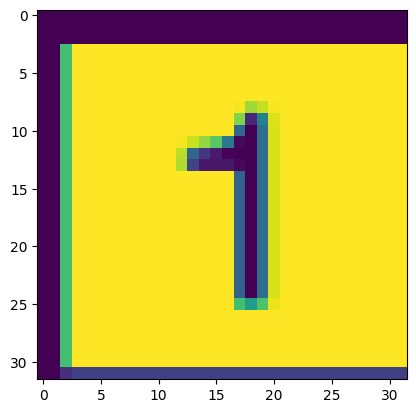

In [425]:
# predict a toy image of 1
toy_image = cv2.imread('./images/toy/2022-us-sudoku-grand-prix-round.png', cv2.IMREAD_GRAYSCALE)
toy_image = toy_image[26:70, 29:70]
toy_image = cv2.resize(toy_image,resize_dim)
plt.imshow(toy_image)
# cv2.imshow('Image', toy_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
toy_image = preprocess_pixels(toy_image, resize_dim)
prediction = model.predict(toy_image)
prediction_label = prediction.argmax() + 1
predicted_probability = prediction.max()
print(f'{prediction.round(3) = }')
print(f'{prediction_label = }')
print(f'{predicted_probability = }')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
prediction.round(3) = array([[0.386, 0.09 , 0.073, 0.061, 0.048, 0.052, 0.123, 0.105, 0.062]],
      dtype=float32)
prediction_label = 1
predicted_probability = 0.38616836


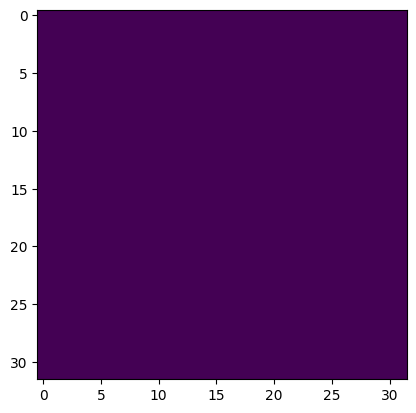

In [426]:
# predict a toy image of blank
toy_image2 = np.full((32, 32), 255, dtype=np.uint8)
plt.imshow(toy_image2)
toy_image2 = preprocess_pixels(toy_image2, resize_dim)
prediction = model.predict(toy_image2)
prediction_label = prediction.argmax() + 1
predicted_probability = prediction.max() 
print(f'{prediction.round(3) = }')
print(f'{prediction_label = }')
print(f'{predicted_probability = }')

In [427]:
import os
directory = './images/toy/'
files = os.listdir(directory)
# resize_dim = (32,32)
for file in files:
    if file == '2022-us-sudoku-grand-prix-round.png':
        pass
    else:
        full_path = directory + file
        image = image_to_pixels(full_path, resize_dim)
        image = preprocess_pixels(image, resize_dim)
        prediction = model.predict(image)
        prediction_label = prediction.argmax() + 1
        predicted_probability = prediction.max()
        print(f'{file = }')
        print(f'{prediction.round(3) = }')
        print(f'{prediction_label = }')
        print(f'{predicted_probability = }')
        

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
file = 'my-8.png'
prediction.round(3) = array([[0.011, 0.113, 0.116, 0.012, 0.138, 0.045, 0.028, 0.463, 0.073]],
      dtype=float32)
prediction_label = 8
predicted_probability = 0.46343252
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
file = 'my-9.png'
prediction.round(3) = array([[0.016, 0.007, 0.012, 0.004, 0.001, 0.   , 0.922, 0.004, 0.034]],
      dtype=float32)
prediction_label = 7
predicted_probability = 0.92151177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
file = 'my-4.png'
prediction.round(3) = array([[0.   , 0.   , 0.   , 0.998, 0.   , 0.002, 0.   , 0.   , 0.   ]],
      dtype=float32)
prediction_label = 4
predicted_probability = 0.9976398
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
file = 'my-5.png'
prediction.round(3) = array([[0.   , 0.   , 0.007, 0.001, 0.962, 0.008, 0.001, 0.014, 0.007]],
      dtype=float32)
prediction_label = 5
predicted_probability = 0.9618525
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
file = 'my-7.png'
prediction.round(3) = array([[0.00

In [428]:
model.save('./models/cnn_4.h5')